# Machine Learning Approaches to Ethical Analysis of Statistics (ICS5110)

Aim and Objectives:
* Transform and analyse raw, tabular daily_temp_tsdf from a statistics website.
* Apply multiple machine-learning techniques to this daily_temp_tsdf.
* Investigate and document ethical and social implications.
* Create a data project and analysis related to real-life statistics.
* Deadline: 10th January 2024

Deliverables:
* 20 Pages (Maximum) Document in the IEEE Access format
* Project GitHub Pages Webpage
* 10 Page (Maximum) Generative AI Usage Journal

**IMPORTANT**: For dependencies, running and committing this notebooks, see: [README](./README.md)

## Problem: Energy Consumption vs Temperature vs Population (Malta-based)

Model Outcomes:
* Energy Demand Forecasting

# Data Preparation

## Dataset provenance
Electricity:
- [NSO Table 1. Electricity supply by year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 2. Gross production of electricity by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 3. Electricity production from power plants by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 4. Estimated electricity production from renewable sources by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 5. Imports and exports of electricity by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 6. Electricity supply by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 8. GHG emissions from fuel combustion in power plants by year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [Eurostat Net electricity generation by type of fuel - monthly data](https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_pem__custom_8232363/default/table?lang=en)

Climate:
- [Meteostat Temperature](https://dev.meteostat.net/sources.html)

Population:
- [Population Worldbank](https://data.worldbank.org/country/malta)

Indutrial Indices:
- [NSO Index of Industrial Production November 2018](https://nso.gov.mt/wp-content/uploads/News2019_003.pdf)
- [NSO Index of Industrial Production December 2018](https://nso.gov.mt/wp-content/uploads/News2019_019.pdf)
- [NSO Index of Industrial Production May 2020](https://nso.gov.mt/wp-content/uploads/News2020_109.pdf)
- [NSO Index of Industrial Production December 2020](https://nso.gov.mt/wp-content/uploads/News2021_020.pdf)
- [NSO Short Term Industrial Indicators Q4 2018](https://nso.gov.mt/wp-content/uploads/News2019_033.pdf)

## Preparation

* **Manual** edit of CSV to delete text, disclaimers and images from NSO. Output is a clean table.
* Removal of **features with >20% NaNs**. Too many gaps to interpolate.
* Drop data **> 3 standard deviations**.
* Resample to 22years from **2000 to 2022**.
* Normalize and reduce data. E.g. Mega Watts to Giga Watts, Minutes to Days, etc.
* Linear **interpolation of NaNs**.

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Constants here
START_DATE = datetime(2000, 1, 1)
END_DATE = datetime(2022, 12, 31)

# All unprocessed CVs should go here.
RAW_DATA_PATH = './raw_data'
ELECTRIC_DS = ['Max_Demand_MW.csv', 'Supply_MWh.csv', 'GrossProduction_MWh.csv',
               'Plant_Production_MWh.csv', 'Imports_MWh.csv', 'Exports_MWh.csv',
               'Renewables_Production_MWh.csv']

all_data_df = None  # Main Dataset DF.

for filename in ELECTRIC_DS:
    file_path = os.path.join(RAW_DATA_PATH, filename)

    # Convert mega to giga
    value_col = filename.split(".")[0].replace("_MW", "_GW")
    print(filename)
    df = pd.read_csv(file_path)

    # Melt this 3 col daily_temp_tsdf in 2 col timeseries
    melted_df = df.melt(id_vars=['Month'],
                        var_name='Year', value_name=value_col)

    melted_df[value_col] = melted_df[value_col].apply(lambda x: float(
        str(x).replace(',', '')) / 1000 if isinstance(x, str) else x)

    melted_df['Date'] = pd.to_datetime(
        melted_df['Month'] + ' ' + melted_df['Year'], format='%B %Y')

    melted_df.dropna(inplace=True)
    melted_df.set_index('Date', inplace=True, drop=True)
    melted_df.index = pd.to_datetime(melted_df.index)
    melted_df = melted_df[(melted_df.index >= START_DATE)
                          & (melted_df.index <= END_DATE)]
    result_df = melted_df[[value_col]]

    if all_data_df is None:
        all_data_df = result_df
    else:
        all_data_df = pd.concat(
            [all_data_df, result_df], axis=1, ignore_index=False)

all_data_df.tail(3)

Max_Demand_MW.csv
Supply_MWh.csv
GrossProduction_MWh.csv
Plant_Production_MWh.csv
Imports_MWh.csv
Exports_MWh.csv
Renewables_Production_MWh.csv


,Max_Demand_GW,Supply_GWh,GrossProduction_GWh,Plant_Production_GWh,Imports_GWh,Exports_GWh,Renewables_Production_GWh
Date,,,,,,,
2022-10-01,411,225.886,164.124,140.278,66.130,0.121,23.846
2022-11-01,411,206.396,199.398,182.610,13.054,1.497,16.788
2022-12-01,404,207.776,193.126,177.287,22.018,2.630,15.839


In [2]:
ENERGY_PROD = "energy_production.csv"

electric_prod_df = pd.read_csv(f"{RAW_DATA_PATH}/{ENERGY_PROD}")
electric_prod_df = electric_prod_df.T
electric_prod_df.columns = ["GWH"]
electric_prod_df.index = pd.to_datetime(electric_prod_df.index, format='%Y-%m')

electric_prod_df = electric_prod_df[(electric_prod_df.index >= START_DATE) & (
    electric_prod_df.index <= END_DATE)]
electric_prod_df = electric_prod_df.interpolate().bfill().ffill()
electric_prod_df = electric_prod_df[(electric_prod_df.index >= START_DATE) & (
    electric_prod_df.index <= END_DATE)]

all_data_df = pd.concat([all_data_df, electric_prod_df],
                        axis=1, ignore_index=False)
all_data_df.tail(3)

,Max_Demand_GW,Supply_GWh,GrossProduction_GWh,Plant_Production_GWh,Imports_GWh,Exports_GWh,Renewables_Production_GWh,GWH
2022-10-01,411.0,225.886,164.124,140.278,66.130,0.121,23.846,158.828
2022-11-01,411.0,206.396,199.398,182.610,13.054,1.497,16.788,193.908
2022-12-01,404.0,207.776,193.126,177.287,22.018,2.630,15.839,187.516


In [3]:
POP_DS = "malta_population.csv"

pop_df = pd.read_csv(f"{RAW_DATA_PATH}/{POP_DS}")
pop_df = pop_df.T
pop_df.columns = ["Population"]

# Indexed on year only, resample to monthly. interpolate everything.
pop_df.index = pd.to_datetime(pop_df.index, format='%Y')
pop_df = pop_df.resample('M').mean()
pop_df = pop_df[(pop_df.index >= START_DATE) & (pop_df.index <= END_DATE)]

# resample puts it on the last day of the month!
pop_df.index = pop_df.index.to_period(
    'M').to_timestamp('M') + pd.DateOffset(days=1)

# Population is missing the last months from the resample.
all_data_df = pd.concat([all_data_df, pop_df], axis=1, ignore_index=False)
all_data_df['Population'] = all_data_df['Population'].interpolate().ffill().bfill()

all_data_df.tail(3)

,Max_Demand_GW,Supply_GWh,GrossProduction_GWh,Plant_Production_GWh,Imports_GWh,Exports_GWh,Renewables_Production_GWh,GWH,Population
2022-10-01,411.0,225.886,164.124,140.278,66.130,0.121,23.846,158.828,523417.0
2022-11-01,411.0,206.396,199.398,182.610,13.054,1.497,16.788,193.908,523417.0
2022-12-01,404.0,207.776,193.126,177.287,22.018,2.630,15.839,187.516,523417.0


In [4]:
from meteostat import Point, Daily, Monthly
import pandas as pd

# Create Point for Malta - specify latitude and longitude
malta = Point(35.8992, 14.5141)
temp_data_df = Monthly(malta, START_DATE, END_DATE)
temp_data_df = temp_data_df.fetch()
temp_data_df = temp_data_df[(temp_data_df.index >= START_DATE) & (
    temp_data_df.index <= END_DATE)]

temp_data_df.index = pd.to_datetime(temp_data_df.index, format='%Y-%m-%d')
temp_data_df = temp_data_df.interpolate().bfill()

all_data_df = pd.concat([all_data_df, temp_data_df],
                        axis=1, ignore_index=False)

all_data_df.tail(3)

,Max_Demand_GW,Supply_GWh,GrossProduction_GWh,Plant_Production_GWh,Imports_GWh,Exports_GWh,Renewables_Production_GWh,GWH,Population,tavg,tmin,tmax,prcp,wspd,pres,tsun
2022-10-01,411.0,225.886,164.124,140.278,66.130,0.121,23.846,158.828,523417.0,21.6,18.2,25.3,15.8,11.2,1021.4,9060.0
2022-11-01,411.0,206.396,199.398,182.610,13.054,1.497,16.788,193.908,523417.0,18.0,15.1,21.3,102.7,16.4,1016.1,9060.0
2022-12-01,404.0,207.776,193.126,177.287,22.018,2.630,15.839,187.516,523417.0,16.3,13.2,19.4,5.4,13.9,1018.9,9060.0


In [5]:
# In case indices failed to align.
all_data_df = all_data_df.interpolate().ffill().bfill()
all_data_df.sample(5)

,Max_Demand_GW,Supply_GWh,GrossProduction_GWh,Plant_Production_GWh,Imports_GWh,Exports_GWh,Renewables_Production_GWh,GWH,Population,tavg,tmin,tmax,prcp,wspd,pres,tsun
2011-09-01,371.0,201.163,115.354,105.053,88.723,0.021,10.301,59.00,418461.333333,25.2,21.1,29.3,7.0,12.5,1015.6,16260.0
2006-09-01,371.0,201.163,115.354,105.053,88.723,0.021,10.301,59.00,406134.000000,24.1,20.7,27.5,24.0,12.5,1015.7,15060.0
2012-07-01,371.0,201.163,115.354,105.053,88.723,0.021,10.301,59.00,422502.583333,28.5,23.4,33.6,0.0,12.5,1013.7,22680.0
2020-05-01,321.0,173.347,172.373,146.160,7.354,1.328,26.213,166.91,516133.000000,21.2,17.3,25.1,28.0,18.2,1016.5,17160.0
2008-03-01,371.0,201.163,115.354,105.053,88.723,0.021,10.301,59.00,409637.166667,14.9,12.1,17.7,53.0,12.5,1012.2,13440.0


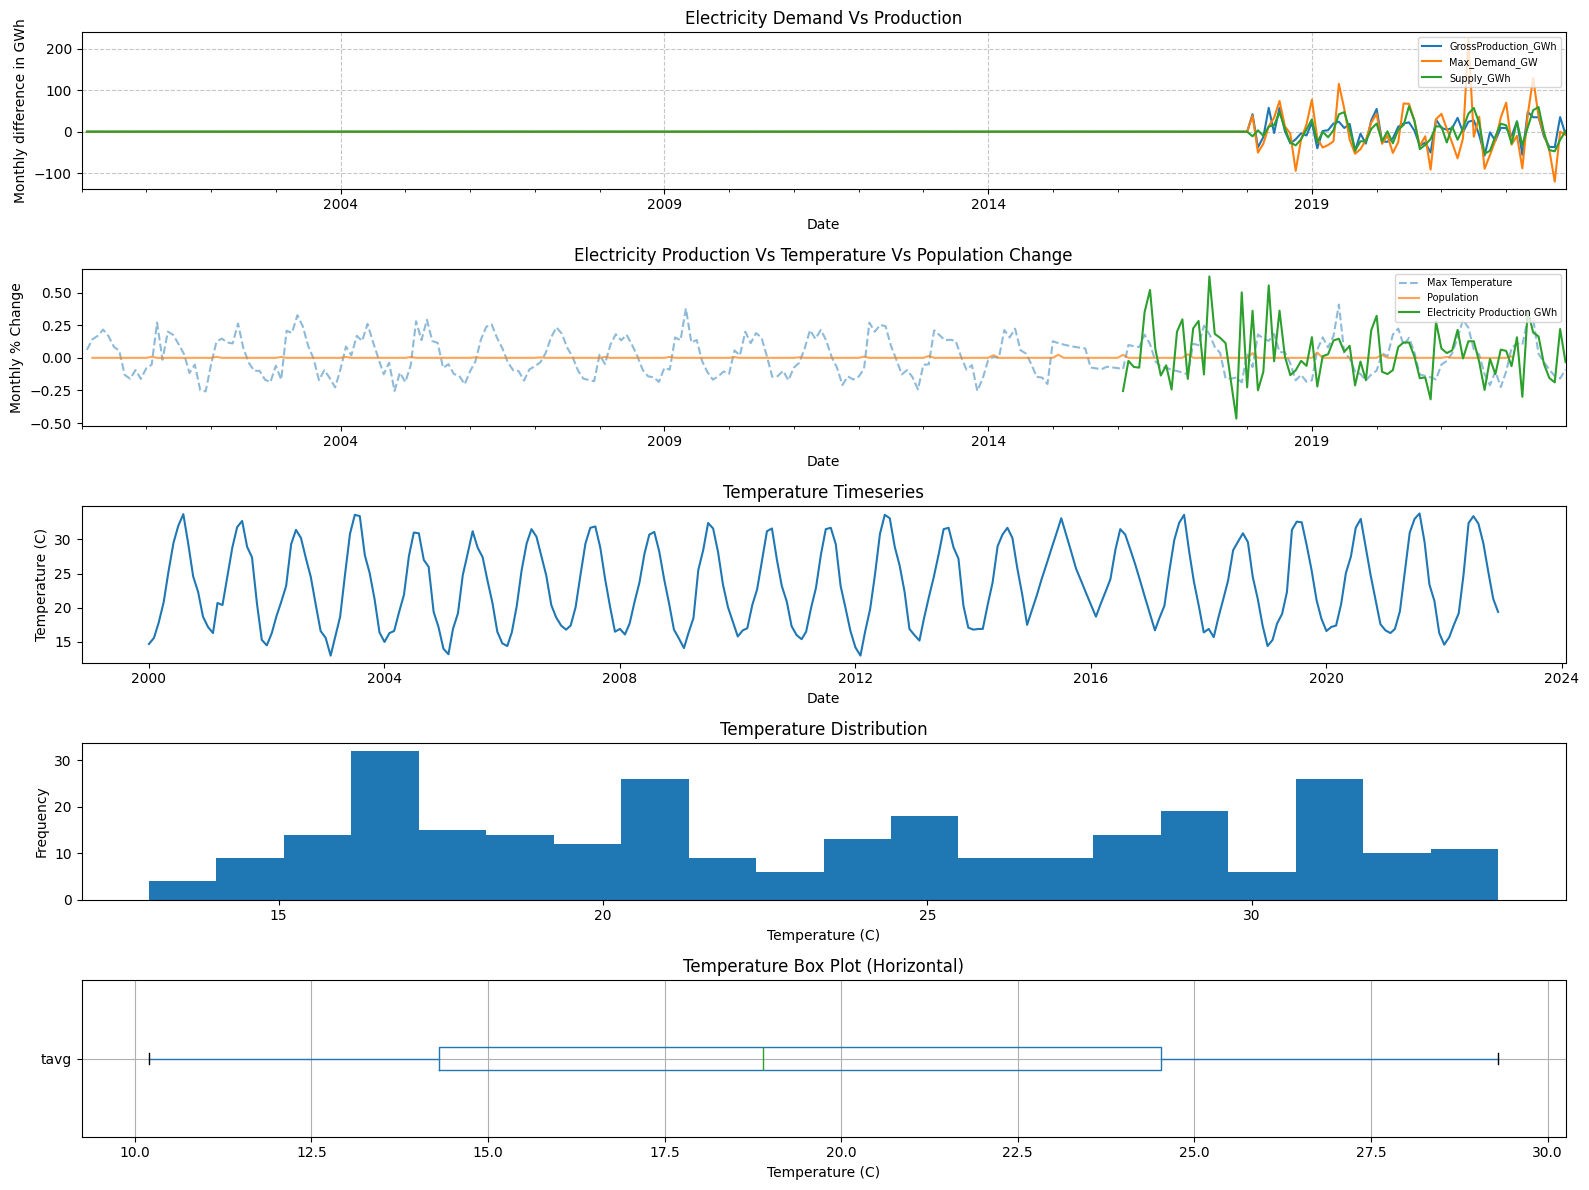

In [6]:
prod_cols = ['GrossProduction_GWh', 'Max_Demand_GW', 'Supply_GWh']
import_export_cols = ['Imports_GWh', 'Exports_GWh']
renew_cols = ['Renewables_Production_GWh', 'Supply_GWh']
temp_data = temp_data_df['tmax']

fig, axes = plt.subplots(5, 1, figsize=(16, 12))

all_data_df[prod_cols].diff().plot(kind='line', ax=axes[0])
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Monthly difference in GWh')
axes[0].grid(axis='both', linestyle='--', alpha=0.7)
axes[0].set_title('Electricity Demand Vs Production')
axes[0].legend(fontsize=7, loc='upper right')

temp_data.pct_change().plot(
    kind='line', ax=axes[1], linestyle='--', alpha=0.5, label="Max Temperature")
pop_df.pct_change().plot(
    kind='line', ax=axes[1], alpha=0.7, label="Population")
electric_prod_df["GWH"].pct_change().plot(
    kind='line', ax=axes[1], label="Electricity Production GWh")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Monthly % Change')
axes[1].set_title('Electricity Production Vs Temperature Vs Population Change')
axes[1].legend(fontsize=7, loc='upper right')

axes[2].plot(temp_data)
axes[2].set_ylabel('Temperature (C)')
axes[2].set_xlabel('Date')
axes[2].set_title('Temperature Timeseries')

axes[3].hist(temp_data, bins=20)
axes[3].set_xlabel('Temperature (C)')
axes[3].set_ylabel('Frequency')
axes[3].set_title('Temperature Distribution')

all_data_df.boxplot(column='tavg', vert=False)
axes[4].set_title('Temperature Box Plot (Horizontal)')
axes[4].set_xlabel('Temperature (C)')

plt.tight_layout()
plt.show()

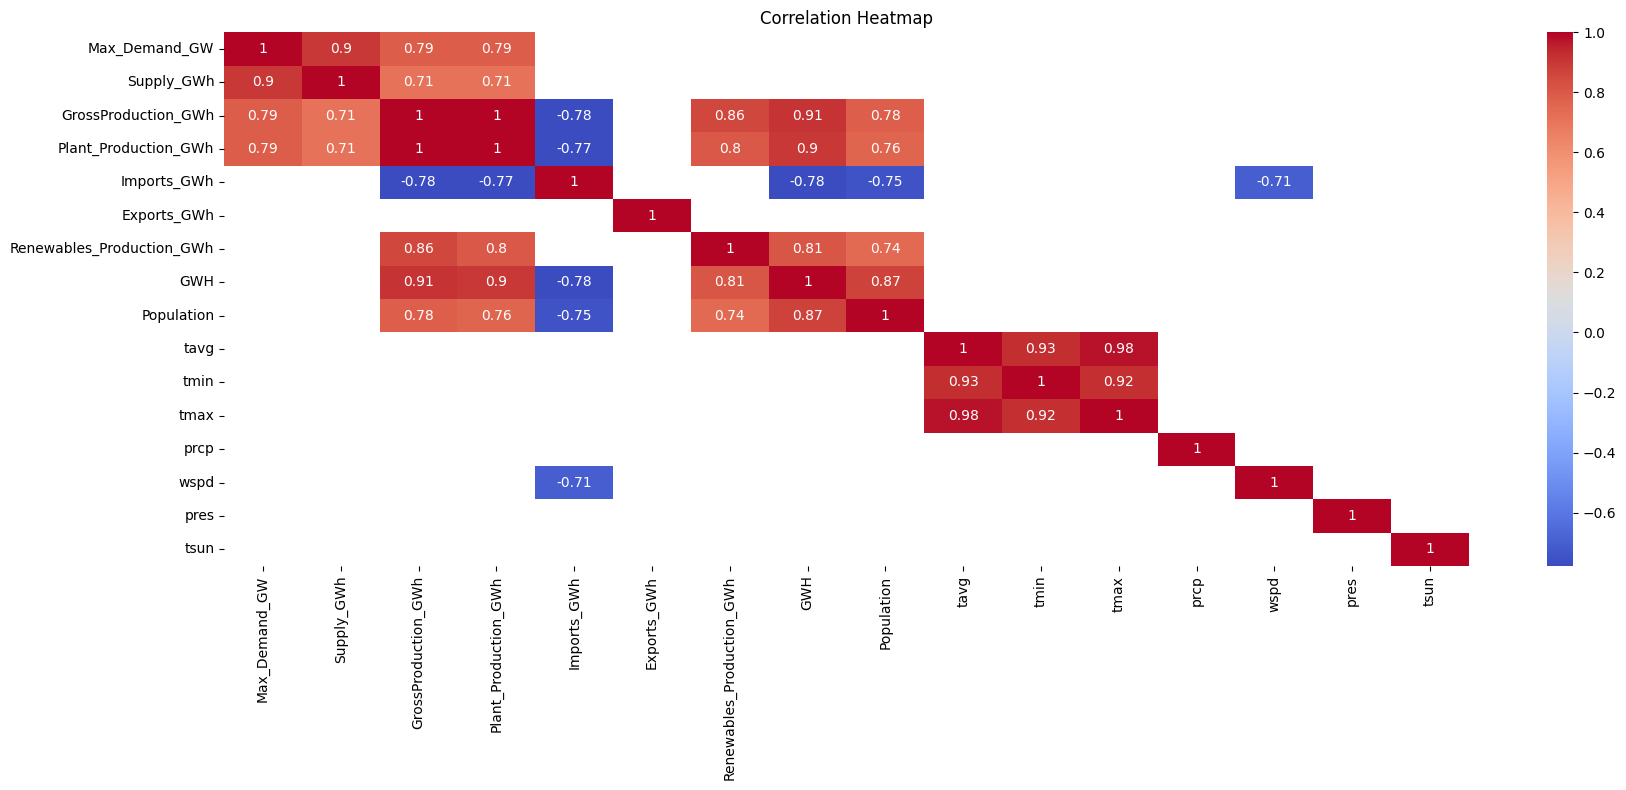

In [7]:
import seaborn as sns

plt.figure(figsize=(18, 8))

CR_THRESHOLD = 0.7

corr_matrix = all_data_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
            mask=(np.abs(corr_matrix) <= CR_THRESHOLD))
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df, test_validate_df = train_test_split(
    all_data_df, test_size=0.3, random_state=42)
test_df, validate_df = train_test_split(
    test_validate_df, test_size=0.5, random_state=42)

train_df.to_csv('./data/train_data.csv', index=True)
test_df.to_csv('./data/test_data.csv', index=True)
validate_df.to_csv('./data/validate_data.csv', index=True)